In [11]:
%matplotlib inline


# K-NN on the MNIST dataset - PyTorch API

The :mod:`.argKmin(K)` reduction supported by KeOps :class:`pykeops.torch.LazyTensor` allows us
to perform **bruteforce k-nearest neighbors search** with four lines of code.
It can thus be used to implement a **large-scale** 
`K-NN classifier <https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm>`_,
**without memory overflows** on the 
full `MNIST <http://yann.lecun.com/exdb/mnist/>`_ dataset.


## Setup
Standard imports:



In [12]:
import time

import torch
from matplotlib import pyplot as plt

from pykeops.torch import LazyTensor

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

Load the MNIST dataset: 70,000 images of shape (28,28).



In [13]:
try:
    from sklearn.datasets import fetch_openml
except ImportError:
    raise ImportError("This tutorial requires Scikit Learn version >= 0.20.")

mnist = fetch_openml("mnist_784", cache=False, as_frame=False)

x = tensor(mnist.data.astype("float32"))
y = tensor(mnist.target.astype("int64"))

Split it into a train and test set:



In [14]:
D = x.shape[1]
Ntrain, Ntest = (60000, 10000) if use_cuda else (1000, 100)
x_train, y_train = x[:Ntrain, :].contiguous(), y[:Ntrain].contiguous()
x_test, y_test = (
    x[Ntrain : Ntrain + Ntest, :].contiguous(),
    y[Ntrain : Ntrain + Ntest].contiguous(),
)

## K-Nearest Neighbors search
Perform the K-NN classification on 10,000 test images in dimension 784:




In [15]:
K = 3  # N.B.: K has very little impact on the running time

start = time.time()  # Benchmark:

X_i = LazyTensor(x_test[:, None, :])  # (10000, 1, 784) test set
X_j = LazyTensor(x_train[None, :, :])  # (1, 60000, 784) train set
D_ij = ((X_i - X_j) ** 2).sum(
    -1
)  # (10000, 60000) symbolic matrix of squared L2 distances

ind_knn = D_ij.argKmin(K, dim=1)  # Samples <-> Dataset, (N_test, K)
lab_knn = y_train[ind_knn]  # (N_test, K) array of integers in [0,9]
y_knn, _ = lab_knn.mode()  # Compute the most likely label

if use_cuda:
    torch.cuda.synchronize()
end = time.time()

error = (y_knn != y_test).float().mean().item()
time = end - start

print(
    "{}-NN on the full MNIST dataset: test error = {:.2f}% in {:.2f}s.".format(
        K, error * 100, time
    )
)

3-NN on the full MNIST dataset: test error = 20.00% in 0.15s.


Fancy display: looks good!



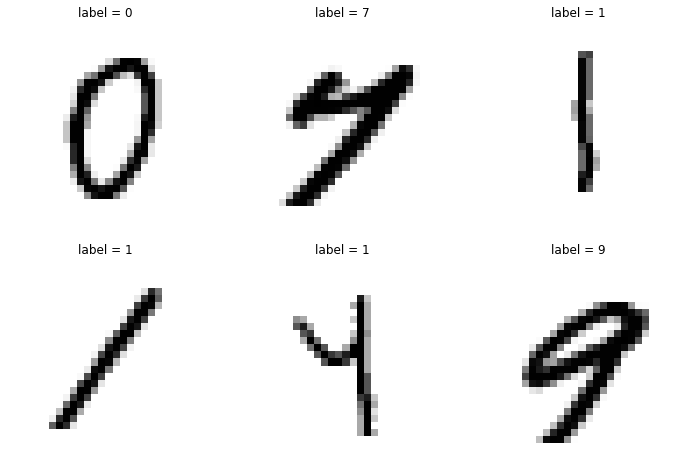

In [16]:
plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow((255 - x_test[i]).view(28, 28).detach().cpu().numpy(), cmap="gray")
    ax.set_title("label = {}".format(y_knn[i].int()))
    plt.axis("off")

plt.show()